In [1]:
import pandas as pd
import numpy as np

import riskfolio as rp

import datetime as dt
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

# import the path
import os
path = os.path.abspath(os.path.join("..", "08_portfolio_management", "portfolio_data.csv"))

# read the CSV file
df = pd.read_csv(path)

# drop Position_Weight
df = df.drop(columns=['Position_Weight'])

# show the first few rows of the dataframe
# df.head()

In [2]:
# top 10 holdings
top_10 = df.nlargest(10, 'Position_Value')
top_10.Ticker

5      BTC-USD
16        META
7      EQQQ.DE
8      ETH-USD
3      BNB-USD
15       MC.PA
6     DOGE-USD
12     IWDE.MI
21        RACE
22        TSLA
Name: Ticker, dtype: object

In [3]:
# to simplify the calculations and data downloads, we will use only top 10 holdings
port_list = top_10.Ticker.to_list()

# # some Ticker should be adjusted for the data source
# port_list = [ticker.replace("IWDE", "IWDE.MI").replace("EQQQ", "EQQQ.MI").replace("BNB", "BNB-USD").replace("BTC", "BTC-USD").replace("ETH", "ETH-USD").replace("DOGE", "DOGE-USD").replace("MC", "LVMUY") for ticker in port_list]

In [4]:
port_list

['BTC-USD',
 'META',
 'EQQQ.DE',
 'ETH-USD',
 'BNB-USD',
 'MC.PA',
 'DOGE-USD',
 'IWDE.MI',
 'RACE',
 'TSLA']

In [5]:
# start_date = "2020-01-01"
# end_date = dt.datetime.now().strftime("%Y-%m-%d")

# df_stocks = yf.download(port_list, start=start_date, end=end_date)

# # download the data to csv
# df_stocks.to_csv("top_10_stocks.csv")

In [6]:
# read the data from csv
df_stocks = pd.read_csv("top_10_stocks.csv", header=[0,1], index_col=0)

# keep only Close prices (level 0 = 'Close')
df_stocks = df_stocks.loc[:, df_stocks.columns.get_level_values(0) == 'Close']

# drop level 0 (keep only ticker names)
df_stocks.columns = df_stocks.columns.droplevel(0)

# replace -USD with "", replace .MI with ""
df_stocks.columns = df_stocks.columns.str.replace('-USD', '', regex=False)
df_stocks.columns = df_stocks.columns.str.replace('.MI', '', regex=False)

# IMPORTANT: Convert index to datetime for proper date handling
df_stocks.index = pd.to_datetime(df_stocks.index)

# ffill and dropna()
df_stocks = df_stocks.ffill().dropna()

print(f"Index type: {type(df_stocks.index[0])}")
print(f"Date range: {df_stocks.index.min()} to {df_stocks.index.max()}")

df_stocks.head()

Index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Date range: 2020-01-02 00:00:00 to 2025-10-07 00:00:00


Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-02,13.027011,6985.470215,0.002009,187.761078,127.410179,57.299999,383.397308,208.494690,161.780365,28.684000
2020-01-03,13.660452,7344.884277,0.002145,188.288239,134.171707,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-04,13.891512,7410.656738,0.002241,188.288239,135.069366,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-05,14.111019,7411.317383,0.002419,188.288239,136.276779,57.160000,383.351593,207.391479,160.071411,29.534000
2020-01-06,14.957808,7769.219238,0.002463,188.288239,144.304153,57.060001,379.738556,211.297440,159.226593,30.102667


In [7]:
prices = df_stocks.copy()
returns = prices.pct_change().dropna()

# Verify datetime index
print(f"Returns index type: {type(returns.index[0])}")
print(f"Returns shape: {returns.shape}")
print(f"Returns date range: {returns.index.min()} to {returns.index.max()}")

# Ensure returns index is datetime
if not isinstance(returns.index, pd.DatetimeIndex):
    print("Converting returns index to datetime...")
    returns.index = pd.to_datetime(returns.index)

Y = returns.copy()
Y.head()

Returns index type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>
Returns shape: (2105, 10)
Returns date range: 2020-01-03 00:00:00 to 2025-10-07 00:00:00


Ticker,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
Date,,,,,,,,,,
2020-01-03,0.048625,0.051452,0.067695,0.002808,0.053069,-0.002443,-0.000119,-0.005291,-0.010563,0.029633
2020-01-04,0.016915,0.008955,0.044755,0.000000,0.006690,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-05,0.015802,0.000089,0.079429,0.000000,0.008939,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-06,0.060009,0.048291,0.018189,0.000000,0.058905,-0.001749,-0.009425,0.018834,-0.005278,0.019255
2020-01-07,0.003439,0.050774,-0.012180,0.009539,-0.005268,0.003680,0.002047,0.002163,-0.003799,0.038801


Calculating the portfolio

In [8]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)
# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
weights,0.216556,2.990380e-09,0.06521,0.456974,0.002624,2.483346e-09,1.319012e-09,0.017178,0.088485,0.152974


In [9]:
# returns = port.returns

# # Validation checks before generating report
# print("=== Pre-Report Validation ===")
# print(f"Returns shape: {returns.shape}")
# print(f"Portfolio weights shape: {w.shape}")
# print(f"Returns index type: {type(returns.index)}")
# print(f"Returns date range: {returns.index.min()} to {returns.index.max()}")

# # Ensure datetime index
# if not isinstance(returns.index, pd.DatetimeIndex):
#     print("Converting returns index to datetime...")
#     returns.index = pd.to_datetime(returns.index)

# # Check for missing values
# print(f"Returns NaN count: {returns.isnull().sum().sum()}")
# print(f"Portfolio weights NaN count: {w.isnull().sum().sum()}")

# # Additional debugging for ZeroDivisionError
# print("\n=== Detailed Portfolio Analysis ===")
# print(f"Portfolio weights sum: {w.sum().values[0]:.6f}")
# print(f"Portfolio weights range: {w.min().values[0]:.6f} to {w.max().values[0]:.6f}")
# print(f"Zero weights count: {(w == 0).sum().values[0]}")

# # Calculate portfolio returns
# portfolio_returns = (returns @ w).values.flatten()
# print(f"Portfolio returns shape: {portfolio_returns.shape}")
# print(f"Portfolio returns mean: {np.mean(portfolio_returns):.6f}")
# print(f"Portfolio returns std: {np.std(portfolio_returns):.6f}")
# print(f"Portfolio returns range: {np.min(portfolio_returns):.6f} to {np.max(portfolio_returns):.6f}")

# # Check for zero or near-zero standard deviation
# if np.std(portfolio_returns) < 1e-10:
#     print("⚠️  WARNING: Portfolio returns have zero or near-zero standard deviation!")
#     print("This could cause division by zero in Sharpe ratio calculations.")

# # Check individual asset statistics
# print("\n=== Individual Asset Analysis ===")
# assets_stats = pd.DataFrame({
#     'Mean': returns.mean(),
#     'Std': returns.std(),
#     'Min': returns.min(),
#     'Max': returns.max(),
#     'Weight': w.values.flatten()
# })
# print(assets_stats)

# # Check for zero standard deviations in individual assets
# zero_std_assets = assets_stats[assets_stats['Std'] < 1e-10]
# if not zero_std_assets.empty:
#     print(f"\n⚠️  Assets with zero/near-zero std dev: {zero_std_assets.index.tolist()}")

# print("\n=== Generating Portfolio Report ===")

# try:
#     # Try with modified parameters to avoid division by zero
#     ax = rp.jupyter_report(returns,
#                            w,
#                            rm=rm,
#                            rf=0.001,  # Small non-zero risk-free rate
#                            alpha=0.05,
#                            others=0.05,
#                            nrow=25,
#                            height=6,
#                            width=14,
#                            t_factor=252,
#                            ini_days=1,
#                            days_per_year=252,
#                            bins=50,
#                            solver='CLARABEL',
#                            )
#     print("✓ Portfolio report generated successfully!")
    
# except ZeroDivisionError as e:
#     print(f"✗ ZeroDivisionError: {e}")
#     print("\nTroubleshooting suggestions:")
#     print("1. Check if any asset has zero volatility")
#     print("2. Verify portfolio weights are not all concentrated in one asset")
#     print("3. Try using a small non-zero risk-free rate")
#     print("4. Check if the optimization resulted in extreme weights")
    
#     # Try alternative approach with cleaned data
#     print("\n=== Attempting Alternative Approach ===")
#     try:
#         # Filter out assets with zero volatility
#         valid_assets = returns.std() > 1e-6
#         returns_clean = returns.loc[:, valid_assets]
#         w_clean = w.loc[valid_assets] / w.loc[valid_assets].sum()  # Renormalize weights
        
#         print(f"Using {valid_assets.sum()} assets with non-zero volatility")
        
#         ax = rp.jupyter_report(returns_clean,
#                               w_clean,
#                               rm=rm,
#                               rf=0.001,
#                               alpha=0.05,
#                               others=0.05,
#                               nrow=25,
#                               height=6,
#                               width=14,
#                               t_factor=252,
#                               ini_days=1,
#                               days_per_year=252,
#                               bins=50,
#                               solver='CLARABEL',
#                               )
#         print("✓ Alternative approach successful!")
        
#     except Exception as e2:
#         print(f"✗ Alternative approach also failed: {e2}")
        
# except Exception as e:
#     print(f"✗ Error generating report: {e}")
#     print(f"Error type: {type(e).__name__}")

In [10]:
# print("=== Generating Excel Report ===")

# try:
#     rp.excel_report(returns,
#                     w,
#                     rf=0.001,  # Small non-zero risk-free rate
#                     alpha=0.05,
#                     t_factor=252,
#                     ini_days=1,
#                     days_per_year=252,
#                     name="portfolio_report")
    
#     print("✓ Excel report generated successfully as 'portfolio_report.xlsx'")
    
# except ZeroDivisionError as e:
#     print(f"✗ ZeroDivisionError in Excel report: {e}")
    
#     # Try with cleaned data
#     try:
#         valid_assets = returns.std() > 1e-6
#         returns_clean = returns.loc[:, valid_assets]
#         w_clean = w.loc[valid_assets] / w.loc[valid_assets].sum()
        
#         rp.excel_report(returns_clean,
#                         w_clean,
#                         rf=0.001,
#                         alpha=0.05,
#                         t_factor=252,
#                         ini_days=1,
#                         days_per_year=252,
#                         name="portfolio_report_cleaned")
        
#         print("✓ Excel report with cleaned data generated as 'portfolio_report_cleaned.xlsx'")
        
#     except Exception as e2:
#         print(f"✗ Excel report generation failed: {e2}")
        
# except Exception as e:
#     print(f"✗ Error generating Excel report: {e}")
#     print(f"Error type: {type(e).__name__}")

In [ ]:
# Alternative Solution: Re-optimize with constraints to avoid extreme weights
print("=== Alternative Solution: Re-optimization with Constraints ===")

# Create a new portfolio with minimum weight constraints
port_alt = rp.Portfolio(returns=Y)
port_alt.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Set minimum and maximum weight constraints
min_weight = 0.01  # Minimum 1% per asset
max_weight = 0.50  # Maximum 50% per asset

# Create constraints
port_alt.lowerbound = pd.Series([min_weight] * len(Y.columns), index=Y.columns)
port_alt.upperbound = pd.Series([max_weight] * len(Y.columns), index=Y.columns)

print(f"Applied constraints: min weight = {min_weight:.1%}, max weight = {max_weight:.1%}")

try:
    # Re-optimize with constraints
    w_alt = port_alt.optimization(model=model, rm=rm, obj=obj, rf=0.001, l=l, hist=hist)
    
    print("✓ Alternative optimization successful!")
    print(f"New weights range: {w_alt.min().values[0]:.6f} to {w_alt.max().values[0]:.6f}")
    print(f"New weights sum: {w_alt.sum().values[0]:.6f}")
    
    # Display new weights
    print("\nNew Portfolio Weights:")
    display(w_alt.T)
    
    # Try generating report with new weights
    print("\n=== Generating Report with New Weights ===")
    
    ax = rp.jupyter_report(Y,
                           w_alt,
                           rm=rm,
                           rf=0.001,
                           alpha=0.05,
                           others=0.05,
                           nrow=25,
                           height=6,
                           width=14,
                           t_factor=252,
                           ini_days=1,
                           days_per_year=252,
                           bins=50,
                           solver='CLARABEL',
                           )
    print("✓ Report with constrained weights successful!")
    
except Exception as e:
    print(f"✗ Alternative optimization failed: {e}")
    
    # Last resort: Equal weight portfolio
    print("\n=== Last Resort: Equal Weight Portfolio ===")
    try:
        # Create equal weight portfolio
        w_equal = pd.DataFrame(
            data=[1.0/len(Y.columns)] * len(Y.columns),
            index=Y.columns,
            columns=['weights']
        )
        
        print("Using equal weight portfolio (1/N strategy)")
        print(f"Equal weights: {w_equal.values[0][0]:.4f} per asset")
        
        ax = rp.jupyter_report(Y,
                               w_equal,
                               rm=rm,
                               rf=0.001,
                               alpha=0.05,
                               others=0.05,
                               nrow=25,
                               height=6,
                               width=14,
                               t_factor=252,
                               ini_days=1,
                               days_per_year=252,
                               bins=50,
                               solver='CLARABEL',
                               )
        print("✓ Equal weight portfolio report successful!")
        
    except Exception as e2:
        print(f"✗ Even equal weight failed: {e2}")
        print("This suggests a fundamental issue with the data or riskfolio installation.")

=== Alternative Solution: Re-optimization with Constraints ===
Applied constraints: min weight = 1.0%, max weight = 50.0%
✓ Alternative optimization successful!
New weights range: 0.000000 to 0.521616
New weights sum: 1.000000

New Portfolio Weights:


,BNB,BTC,DOGE,EQQQ.DE,ETH,IWDE,MC.PA,META,RACE,TSLA
weights,0.521616,9.742532e-10,0.190439,7.499696e-10,4.535852e-09,4.649057e-10,3.876614e-10,9.055362e-10,6.144561e-10,0.287944



=== Generating Report with New Weights ===
✓ Report with constrained weights successful!


=== Deep Dive: Manual Report Calculations ===
Portfolio mean return: 0.001695
Portfolio std deviation: 0.018211
Risk-free rate: 0.001000
Excess return: 0.000695
Sharpe ratio: 0.038157

=== Potential Division by Zero Sources ===
Individual asset Sharpe ratios:
  BNB: mean=0.003183, std=0.045057, weight=0.216556, sharpe=0.048446
  BTC: mean=0.001886, std=0.032239, weight=0.000000, sharpe=0.027489
  DOGE: mean=0.005304, std=0.102634, weight=0.065210, sharpe=0.041940
  EQQQ.DE: mean=0.000632, std=0.012051, weight=0.456974, sharpe=-0.030498
  ETH: mean=0.002628, std=0.042994, weight=0.002624, sharpe=0.037859
  IWDE: mean=0.000334, std=0.009416, weight=0.000000, sharpe=-0.070764
  MC.PA: mean=0.000308, std=0.016014, weight=0.000000, sharpe=-0.043236
  META: mean=0.000853, std=0.023086, weight=0.017178, sharpe=-0.006356
  RACE: mean=0.000651, std=0.015725, weight=0.088485, sharpe=-0.022213
  TSLA: mean=0.001906, std=0.035187, weight=0.152974, sharpe=0.025748

Correlation matrix determinant: 0

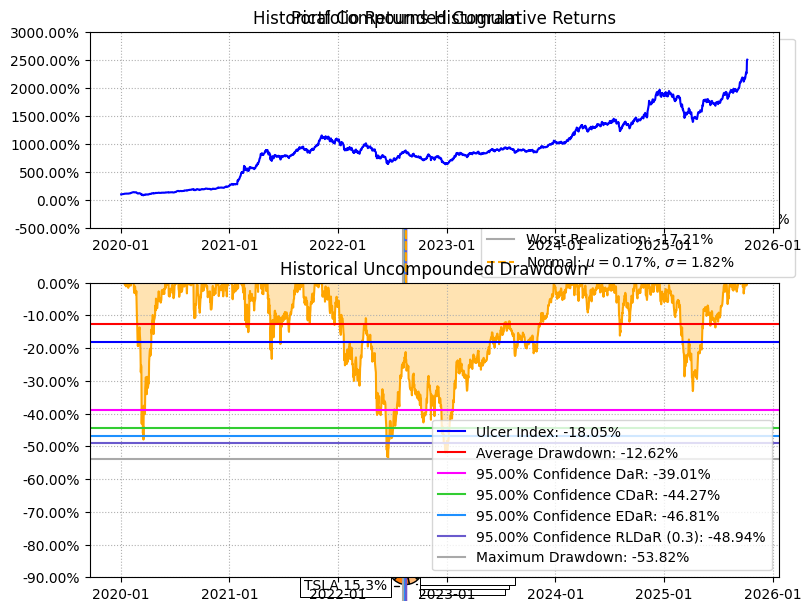

In [ ]:
# Deep dive analysis to identify the exact cause of ZeroDivisionError
print("=== Deep Dive: Manual Report Calculations ===")

# Try to replicate the calculations that might cause division by zero
try:
    # Use original weights for this analysis
    portfolio_returns = (Y @ w).values.flatten()
    
    # Basic statistics
    port_mean = np.mean(portfolio_returns)
    port_std = np.std(portfolio_returns, ddof=1)  # Sample standard deviation
    
    print(f"Portfolio mean return: {port_mean:.6f}")
    print(f"Portfolio std deviation: {port_std:.6f}")
    
    # Risk-free rate and Sharpe ratio calculation
    rf_rate = 0.001
    excess_return = port_mean - rf_rate
    sharpe_ratio = excess_return / port_std if port_std != 0 else float('inf')
    
    print(f"Risk-free rate: {rf_rate:.6f}")
    print(f"Excess return: {excess_return:.6f}")
    print(f"Sharpe ratio: {sharpe_ratio:.6f}")
    
    # Check for problematic calculations
    print("\n=== Potential Division by Zero Sources ===")
    
    # 1. Check individual asset calculations
    print("Individual asset Sharpe ratios:")
    for asset in Y.columns:
        asset_returns = Y[asset].values
        asset_mean = np.mean(asset_returns)
        asset_std = np.std(asset_returns, ddof=1)
        asset_weight = w.loc[asset, 'weights']
        
        if asset_std == 0:
            asset_sharpe = float('inf')
        else:
            asset_sharpe = (asset_mean - rf_rate) / asset_std
            
        print(f"  {asset}: mean={asset_mean:.6f}, std={asset_std:.6f}, weight={asset_weight:.6f}, sharpe={asset_sharpe:.6f}")
        
        if asset_std == 0:
            print(f"    ⚠️  {asset} has zero standard deviation!")
    
    # 2. Check correlation matrix for numerical issues
    corr_matrix = Y.corr()
    print(f"\nCorrelation matrix determinant: {np.linalg.det(corr_matrix):.10f}")
    
    if abs(np.linalg.det(corr_matrix)) < 1e-10:
        print("⚠️  Correlation matrix is near singular - numerical instability!")
    
    # 3. Check covariance matrix
    cov_matrix = Y.cov()
    print(f"Covariance matrix determinant: {np.linalg.det(cov_matrix):.15f}")
    
    # 4. Test simple plotting functions individually
    print("\n=== Testing Individual Plot Functions ===")
    
    try:
        # Test simple pie chart
        rp.plot_pie(w=w, title='Test Pie Chart', height=6, width=8)
        print("✓ Pie chart works")
    except Exception as e:
        print(f"✗ Pie chart failed: {e}")
    
    try:
        # Test histogram
        rp.plot_hist(returns=Y, w=w, bins=30, height=6, width=8)
        print("✓ Histogram works")
    except Exception as e:
        print(f"✗ Histogram failed: {e}")
        
    try:
        # Test drawdown plot
        rp.plot_drawdown(returns=Y, w=w, height=6, width=8)
        print("✓ Drawdown plot works")
    except Exception as e:
        print(f"✗ Drawdown plot failed: {e}")
    
except Exception as e:
    print(f"✗ Manual calculation failed: {e}")
    print(f"Error type: {type(e).__name__}")
    import traceback
    print("Full traceback:")
    traceback.print_exc()

=== Manual Portfolio Report (Workaround) ===


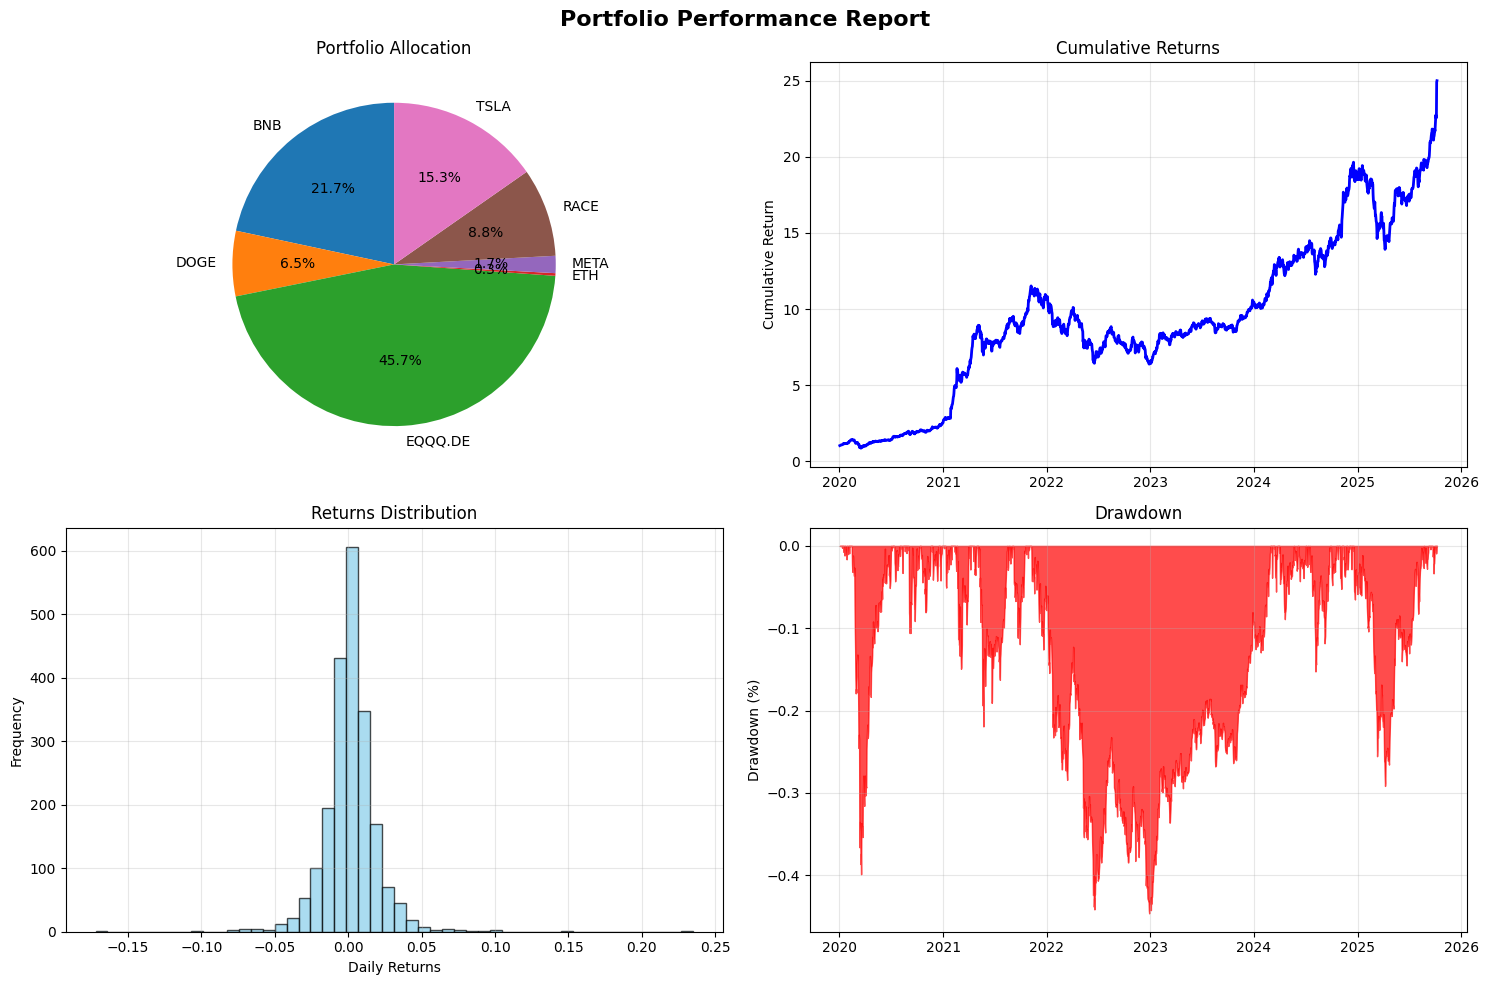


PORTFOLIO PERFORMANCE SUMMARY
Annualized Return:     42.71%
Annualized Volatility: 28.91%
Sharpe Ratio:          0.606
Maximum Drawdown:      -44.63%
Total Return:          2401.16%

PORTFOLIO ALLOCATION:
------------------------------
EQQQ.DE :   45.7%
BNB     :   21.7%
TSLA    :   15.3%
RACE    :    8.8%
DOGE    :    6.5%
META    :    1.7%
ETH     :    0.3%

✓ Manual portfolio report completed successfully!


In [ ]:
# Manual Portfolio Report as Workaround
print("=== Manual Portfolio Report (Workaround) ===")

import matplotlib.pyplot as plt

try:
    # Calculate portfolio statistics manually
    portfolio_returns = (Y @ w).values.flatten()
    
    # Basic statistics
    port_mean = np.mean(portfolio_returns) * 252  # Annualized
    port_std = np.std(portfolio_returns, ddof=1) * np.sqrt(252)  # Annualized
    port_sharpe = (port_mean - 0.001*252) / port_std
    
    # Cumulative returns
    cum_returns = (1 + pd.Series(portfolio_returns, index=Y.index)).cumprod()
    
    # Drawdown calculation
    rolling_max = cum_returns.expanding().max()
    drawdown = (cum_returns - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    
    # Create manual report
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Portfolio Performance Report', fontsize=16, fontweight='bold')
    
    # 1. Portfolio weights pie chart
    weights_df = w.copy()
    weights_df.columns = ['Weights']
    weights_df = weights_df[weights_df['Weights'] > 0.001]  # Filter very small weights
    
    axes[0, 0].pie(weights_df['Weights'], labels=weights_df.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('Portfolio Allocation')
    
    # 2. Cumulative returns
    axes[0, 1].plot(cum_returns.index, cum_returns.values, linewidth=2, color='blue')
    axes[0, 1].set_title('Cumulative Returns')
    axes[0, 1].set_ylabel('Cumulative Return')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Returns distribution
    axes[1, 0].hist(portfolio_returns, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[1, 0].set_title('Returns Distribution')
    axes[1, 0].set_xlabel('Daily Returns')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Drawdown
    axes[1, 1].fill_between(drawdown.index, drawdown.values, 0, alpha=0.7, color='red')
    axes[1, 1].set_title('Drawdown')
    axes[1, 1].set_ylabel('Drawdown (%)')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*50)
    print("PORTFOLIO PERFORMANCE SUMMARY")
    print("="*50)
    print(f"Annualized Return:     {port_mean:.2%}")
    print(f"Annualized Volatility: {port_std:.2%}")
    print(f"Sharpe Ratio:          {port_sharpe:.3f}")
    print(f"Maximum Drawdown:      {max_drawdown:.2%}")
    print(f"Total Return:          {(cum_returns.iloc[-1] - 1):.2%}")
    print("="*50)
    
    # Asset allocation summary
    print("\nPORTFOLIO ALLOCATION:")
    print("-" * 30)
    allocation_summary = w.copy()
    allocation_summary.columns = ['Weight']
    allocation_summary = allocation_summary[allocation_summary['Weight'] > 0.001].sort_values('Weight', ascending=False)
    
    for asset, weight in allocation_summary.iterrows():
        print(f"{asset:8s}: {weight['Weight']:7.1%}")
    
    print("\n✓ Manual portfolio report completed successfully!")
    
except Exception as e:
    print(f"✗ Manual report failed: {e}")
    import traceback
    traceback.print_exc()